# An Implementation of Robust Point Set Registration with GMM

Here is full python implementation script of a robust point set registration method with Gaussian miture models. The original algorithm of this project is from the paper of [Jian B](https://www.ncbi.nlm.nih.gov/pubmed/21173443). The core idea is to compute the integral of 2 GMMs' product over the whole feature space, as a sum of different values taken from zero-point with respect to different Gaussian distributions, which is call closed-form expression. In mathematics, a closed-form expression is a mathematical expression that can be evaluated in a finite number of operations.

I opted TPS (thin-plate spline) transform as the transformation model, thus the implementation works well on registration in non-rigid deformation cases. Users may have choice on TPS kernels or Gaussian Radial Basis kernel (GRBF) in the TPS transform. 

Also, users may choose L2 distance or kernel correlation as object function for optimization.

The registration framework also does well on both 2D and 3D datas. 

The registration framework is robust to noise, and even data that is broken. 

In [1]:
import numpy as np
import os
import math
from scipy.optimize import fmin_bfgs, fmin_l_bfgs_b
import matplotlib.pyplot as plt

%matplotlib inline

# Read Points Coordinates from Text Files

In [2]:
def Read_2D_Points(dir):
    f = open(dir)
    A_str = f.read()
    f.close()
    A_list = []
    flag = 0
    str_temp = ''
    for i in range(len(A_str)):

        if A_str[i] == ' ' or A_str[i] == '\n':
            if flag == 0:
                pass
            elif flag == 1:
                flag = 0
                A_list.append(str_temp)
                str_temp = ''
        else:
            flag = 1
            str_temp = str_temp + A_str[i]
    A_array = np.array(A_list, dtype='float')
    A_x = A_array[0:A_array.shape[0]-1:2]
    A_y = A_array[1:A_array.shape[0]:2]
    A = np.vstack((A_x, A_y)).T
    return A

In [3]:
def Plot_2D_Datasets(A, B, color_1='yo', color_2='b+'):
    fig = plt.figure().add_subplot(111)
    fig.plot(A[:, 0],A[:, 1], color_1 ,markersize=5,mew=1)
    fig.plot(B[:, 0],B[:, 1], color_2 ,markersize=5,mew=1)
    return

In [4]:
def Normalize(X):
    mean = np.mean(X, axis=0)
    sigma = np.sqrt(np.sum(np.square(X), axis=0) - np.square(mean))
    X = (X-mean) / sigma
    return X, mean, sigma

def Denormalize(X, mean, sigma):
    return X * sigma + mean

# Gaussian Mixture Model and Loss Function

We use L2 distance as metrics: $ d_{L_2}(X, Y, \theta) = \int(gmm(Y) - gmm(T(X, \theta))^2dx$,

where $ gmm(x) = \Sigma_i\phi(x|\mu_i, \sigma_i^2)$.

There exists a formula: $ \int\phi(x|\mu_1, \sigma_1^2)\phi(x|\mu_2, \sigma_2^2)dx = \phi(0|\mu_1-\mu_2, \sigma_1^2+\sigma_2^2) $

$\int gmm(X)gmm(Y)dx = \int\Sigma_i\phi(x|\mu_i, \sigma_i^2)\Sigma_j\phi(x|\mu_j, \sigma_j^2)dx = \Sigma_i\Sigma_j\phi(0|\mu_i-\mu_j, \sigma_i^2+\sigma_j^2) = \Sigma_i\Sigma_j\frac{exp(-\frac{1}{2}(X[i]-Y[j])^{T}(\sigma_i^2+\sigma_j^2)^{-1}(X[i]-Y[j]))}{\sqrt{(2\pi)^{d}|det(\sigma_i^2+\sigma_j^2)|}}$

In [5]:
def Compute_L2_Distance(X, Y, dim):
    loss = 0
    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            loss += math.exp(-1/4 * np.dot(X[i]-Y[j], X[i]-Y[j])) / math.sqrt(math.pow(2 * math.pi, dim) * 2)
    return loss
                             
def Compute_L2_Loss(Parameters, Moving, Fixed, Ctrl, kernel, dim):
    Transformed = TPS_Transform(Parameters, Moving, Ctrl, kernel, dim)
    loss1 = Compute_L2_Distance(Transformed, Transformed, dim)
    loss2 = Compute_L2_Distance(Transformed, Fixed, dim)
    loss = loss1 - 2 * loss2
    return loss

def Compute_Kernel_Correlation(Parameters, Moving, Fixed, Ctrl, kernel, dim=2):
    Transformed = TPS_Transform(Parameters, Moving, Ctrl, kernel, dim)
    loss1 = Compute_L2_Distance(Transformed, Transformed, dim)
    loss2 = Compute_L2_Distance(Transformed, Fixed, dim)
    loss = - loss2 * loss2 / loss1

# Non Rigid Spatial Transformation (TPS)

Thin plate splines (TPS) are a spline-based technique for data interpolation and smoothing. The name thin plate spline refers to a physical analogy involving the bending of a thin sheet of metal. Just as the metal has rigidity, the TPS fit resists bending also, implying a penalty involving the smoothness of the fitted surface.

A TPS transform has a rigid part and a non-rigid part. The rigid part is an affine matrix of size $(dim+1, dim)$, while homogeneous coordinate is appended. The non-rigid part is of size $(K, dim)$, where K is the number of control points.

$f_{TPS}(X, Affine, TPS) = X\cdot Affine + \Sigma_{i=1}^{K}\varphi_{i}(X)\cdot TPS(i) = X\cdot Affine + B\cdot TPS$

B is called a TPS basis, which is matrix whose elements $B_{ij} = \varphi(\|X[i]-C[j]\|)$

$\varphi_{i}(X)$ is the kernel function. When we use TPS kernel $\varphi_{i}(X) = X^{2}log(X)$ (for 2D cases). When we use GRBF as kernel, $\varphi_{i}(X) = e^{-X^{2}}$

In [6]:
def Initialize_Transform(Ctrl, dim):
    Affine_Matrix = np.zeros((dim+1, dim))
    for i in range(dim):
        Affine_Matrix[i,i] = 1
    TPS_Matrix = np.zeros((Ctrl.shape[0], dim))
    Affine_Matrix_vectorized = Affine_Matrix.reshape(dim * (dim+1))
    TPS_Matrix_vetorized = TPS_Matrix.reshape((Ctrl.shape[0] * dim))
    Parameters = np.hstack((Affine_Matrix_vectorized, TPS_Matrix_vetorized))
    return Parameters

def TPS_Transform(Parameters, Moving, Ctrl, kernel, dim):
    Affine_Matrix = Parameters[0:(dim+1)*dim].reshape((dim+1, dim))
    TPS_Matrix = Parameters[(dim+1)*dim:dim*(dim+1+Ctrl.shape[0])].reshape((Ctrl.shape[0], dim))
    Ones = np.zeros((Moving.shape[0],1))
    Moving_homo = np.hstack((Moving, Ones))
    assert(Moving_homo.shape == (Moving.shape[0], dim+1))
    Transformed = np.dot(Moving_homo, Affine_Matrix)
    TPS_Basis = Compute_Basis(Moving, Ctrl, kernel, dim)
    Transformed = Transformed + np.dot(TPS_Basis, TPS_Matrix)
    return Transformed

def Compute_Basis(Moving, Ctrl, kernel, dim):
    TPS_Basis = np.zeros((Moving.shape[0], Ctrl.shape[0]))
    for i in range(Moving.shape[0]):
        for j in range(Ctrl.shape[0]):
            TPS_Basis[i, j] = Kernel_Function(np.linalg.norm(Moving[i] - Ctrl[j], ord=2), kernel, dim)
    return TPS_Basis

def Kernel_Function(r, kernel, dim):
    if kernel == 'TPSK':
        if dim == 2:
            if r == 0:
                return 0
            else:
                return r * r * math.log(r)
        if dim == 3:
            return -r
    if kernel == 'GRBF':
        return math.exp(-r*r)


# Optimization

In [11]:
def Run(Moving, Fixed, Ctrl, num_iters=5, kernel='TPSK', metrics='L2', dim=2):
    Parameters = Initialize_Transform(Ctrl, dim)
    if metrics == 'L2':
        NewParameters = fmin_bfgs(Compute_L2_Loss, Parameters, None, args=(Moving, Fixed, Ctrl, kernel, dim), maxiter=num_iters)
    if metrics == 'KC':
        NewParameters = fmin_bfgs(Compute_Kernel_Correlation, Parameters, None, args=(Moving, Fixed, Ctrl, kernel, dim), maxiter=num_iters)
    NewParameters = np.array(NewParameters)
    Transformed = TPS_Transform(NewParameters, Moving, Ctrl, kernel, dim)
    return Transformed, NewParameters

         Current function value: -1054.472842
         Iterations: 5
         Function evaluations: 638
         Gradient evaluations: 11


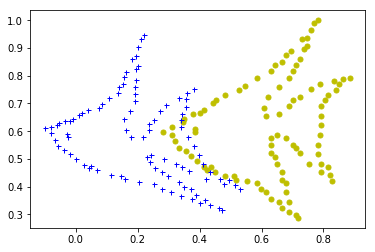

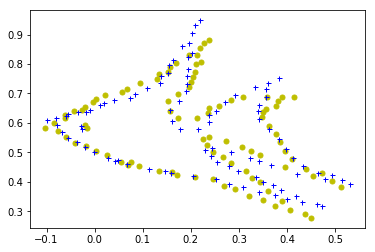

In [12]:
Moving = Read_2D_Points('fish_data/fish_X.txt')
Fixed = Read_2D_Points('fish_data/fish_Y.txt')
Ctrl = Read_2D_Points('fish_data/fish_ctrl_pts.txt')
Plot_2D_Datasets(Moving, Fixed)
'''
Moving_normalized, Moving_mean, Moving_sigma = Normalize(Moving)
Fixed_normalized, Fixed_mean, Fixed_sigma = Normalize(Fixed)
Ctrl_normalized, Ctrl_mean, Ctrl_sigma  = Normalize(Ctrl)
'''
Transformed, NewParameters = Run(Moving, Fixed, Ctrl)
Plot_2D_Datasets(Transformed, Fixed)

In [ ]:
Plot_2D_Datasets(Moving, Fixed)
Plot_2D_Datasets(Transformed, Fixed)

# For No-head and No-tail Fish Data

In [ ]:
Moving = Read_2D_Points('fish_data/fish_X_nohead.txt')
Fixed = Read_2D_Points('fish_data/fish_Y_notail.txt')
Ctrl = Read_2D_Points('fish_data/fish_ctrl_pts.txt')
Plot_2D_Datasets(Moving, Fixed)

Moving_normalized, Moving_mean, Moving_sigma = Normalize(Moving)
Fixed_normalized, Fixed_mean, Fixed_sigma = Normalize(Fixed)
Ctrl_normalized, Ctrl_mean, Ctrl_sigma  = Normalize(Ctrl)
Transformed_normalized, NewParameters = Run(Moving_normalized, Fixed_normalized, Ctrl_normalized)
Transformed = Denormalize(Transformed_normalized, Fixed_mean, Fixed_sigma)
Plot_2D_Datasets(Transformed, Fixed)